In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (194).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(52).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (189).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (186).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (2).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (95).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(14).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (190).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (283).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(101).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (45).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (292).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(76).png
/kaggle/input/coffee-bean-dataset/Coffee Bean

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

2025-08-25 16:41:51.606311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756140111.801001      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756140111.855996      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

base_dir = "/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset"

def create_dataframe(data_dir):
    file_paths = []
    labels = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            file_paths.append(image_path)
            labels.append(class_name)
    
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# build dataframe from all images (no train/test subfolders in dataset)
full_df = create_dataframe(base_dir)

# split into train and test inside the dataframe
train_df, test_df = train_test_split(
    full_df, test_size=0.2, stratify=full_df["label"], random_state=42
)

print("Full dataset shape:", full_df.shape)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Full dataset shape: (1600, 2)
Train shape: (1280, 2)
Test shape: (320, 2)


In [4]:
import os

base_dir = "/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset"
print(os.listdir(base_dir))

['Dark', 'Green', 'Light', 'Medium']


In [5]:
# ----- Cell 3: Data Augmentation and Generators -----
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Validation/Test data only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator (from train_df)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',   # integer labels
    shuffle=True
)

# Test/Validation generator (from test_df)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False  # important for evaluation/prediction
)

# Get number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class indices:", train_generator.class_indices)
print("Number of classes:", num_classes)


Found 1280 validated image filenames belonging to 4 classes.
Found 320 validated image filenames belonging to 4 classes.
Number of classes: 4
Class indices: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Number of classes: 4


Found 1280 validated image filenames belonging to 4 classes.
Found 320 validated image filenames belonging to 4 classes.
Classes: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


I0000 00:00:1756140126.782595      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1756140134.013798      57 service.cc:148] XLA service 0x7c3284006360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756140134.014611      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756140134.633898      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/40 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - accuracy: 0.2188 - loss: 1.3869

I0000 00:00:1756140138.442566      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.3547 - loss: 1.2706 - val_accuracy: 0.9625 - val_loss: 0.1823
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9035 - loss: 0.2596 - val_accuracy: 0.8813 - val_loss: 0.2801
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9413 - loss: 0.1767 - val_accuracy: 0.9469 - val_loss: 0.2157
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9656 - loss: 0.1279 - val_accuracy: 0.9750 - val_loss: 0.0720
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9673 - loss: 0.0776 - val_accuracy: 0.9312 - val_loss: 0.1736
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9467 - loss: 0.1363 - val_accuracy: 0.9031 - val_loss: 0.3837
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9577 - loss: 0.1313 - val_accuracy: 0.8938 - val_loss: 0.2604
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.9790 - loss: 0.0764 - val_accuracy: 0.9531 -

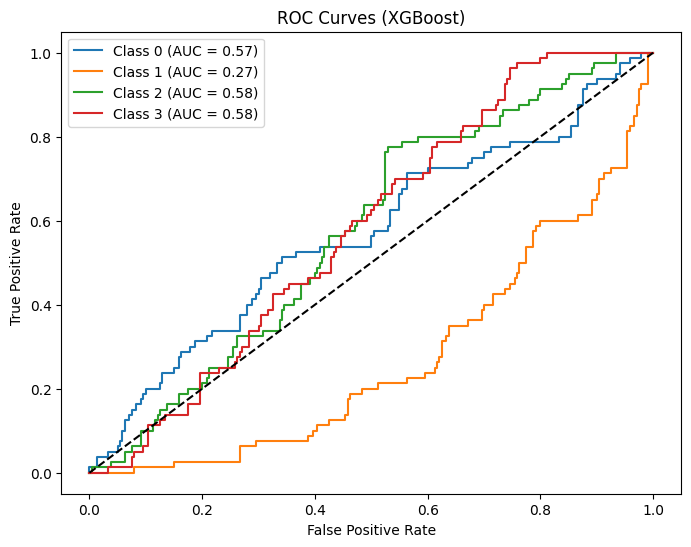

Test AUC: 0.49928385416666665

----- Random Forest -----
Accuracy: 0.2
Precision: 0.21493477045322573
Recall: 0.2
F1-score: 0.20238289082663474
Confusion Matrix:
 [[19 35 22  4]
 [37 14 12 17]
 [15 34 11 20]
 [36 18  6 20]]


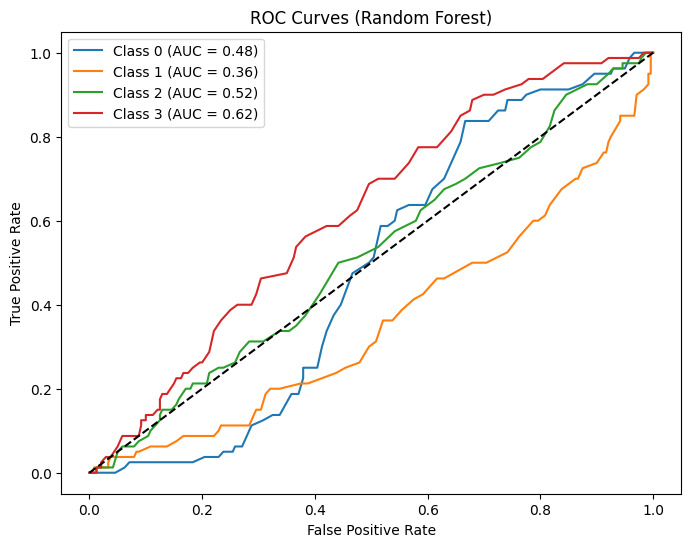

Test AUC: 0.4943294270833334

----- SVM -----
Accuracy: 0.196875
Precision: 0.18259020025920814
Recall: 0.196875
F1-score: 0.18780238141140396
Confusion Matrix:
 [[31  7 39  3]
 [ 0  0  9 71]
 [ 4 53 19  4]
 [67  0  0 13]]


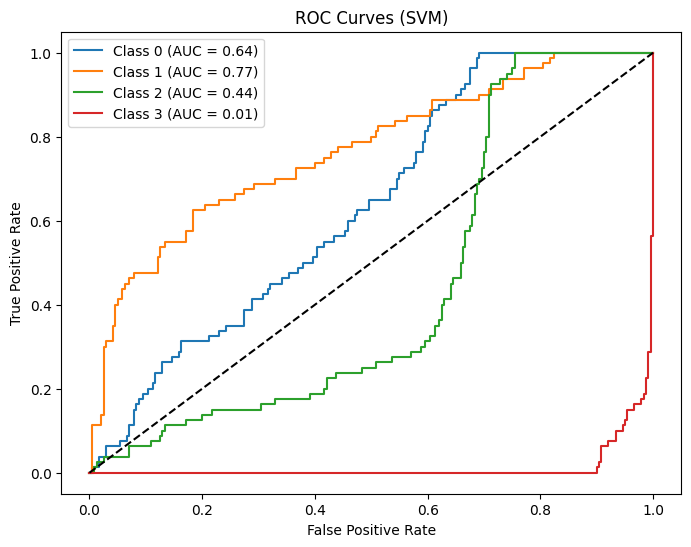

Test AUC: 0.46399739583333327

----- KNN -----
Accuracy: 0.234375
Precision: 0.24334448313782991
Recall: 0.234375
F1-score: 0.22808115833241693
Confusion Matrix:
 [[30 25 18  7]
 [31 18 14 17]
 [30 27 15  8]
 [37 23  8 12]]


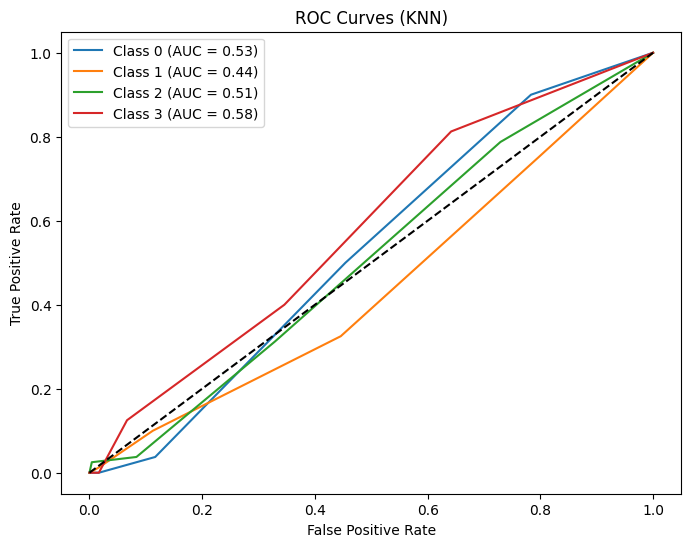

Test AUC: 0.5150065104166667


In [6]:
# ----- Imports -----
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score

from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ML Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ----- SE Block -----
def se_block(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    
    # Squeeze
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1,1,channel))(se)
    
    # Excitation
    se = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal')(se)
    
    # Scale
    x = layers.Multiply()([input_tensor, se])
    return x

# ----- Build SE-CNN -----
def build_se_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)
    
    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)
    
    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)
    
    # Flatten + Dense
    x = layers.Flatten()(x)
    features = layers.Dense(256, activation='relu')(x)   # features for ML models
    x = layers.Dropout(0.5)(features)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    feature_extractor = models.Model(inputs, features)   # feature extractor
    
    return model, feature_extractor

# ----- Data Generators -----
IMG_SIZE = (128,128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Classes:", train_generator.class_indices)

# ----- Train CNN -----
model, feature_extractor = build_se_cnn(num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

# ----- Extract Features -----
def extract_features(generator, feature_model):
    features = feature_model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train_features, y_train_labels = extract_features(train_generator, feature_extractor)
X_test_features, y_test_labels = extract_features(test_generator, feature_extractor)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# ----- Evaluation Function -----
def evaluate_model(clf, X_train, y_train, X_test, y_test, model_name="Model"):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None
    
    print(f"\n----- {model_name} -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1-score:", f1_score(y_test, y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # ROC Curves
    if y_proba is not None:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        if y_test_bin.shape[1] > 1:
            plt.figure(figsize=(8,6))
            for i in range(y_test_bin.shape[1]):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr,tpr):.2f})")
            plt.plot([0,1],[0,1],'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curves ({model_name})")
            plt.legend()
            plt.show()
            print("Test AUC:", roc_auc_score(y_test_bin, y_proba, multi_class='ovr'))

# ----- Run ML Models -----
# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                    objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)
evaluate_model(xgb, X_train_scaled, y_train_labels, X_test_scaled, y_test_labels, "XGBoost")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
evaluate_model(rf, X_train_scaled, y_train_labels, X_test_scaled, y_test_labels, "Random Forest")

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
evaluate_model(svm, X_train_scaled, y_train_labels, X_test_scaled, y_test_labels, "SVM")

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn, X_train_scaled, y_train_labels, X_test_scaled, y_test_labels, "KNN")
